In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 2.5 MB/s eta 0:00:05
     ---------- ----------------------------- 3.4/12.8 MB 5.8 MB/s eta 0:00:02
     ------------------------- -------------- 8.1/12.8 MB 10.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 14.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from time import time
import spacy
import multiprocessing

In [3]:
!wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv
!wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import wget
wget.download('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv')
wget.download('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv')


'news_summary (1).csv'

In [5]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1', sep=',')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1', sep=',')

In [6]:
summary.iloc[0]

author                                            Chhavi Tyagi
date                                      03 Aug 2017,Thursday
headlines    Daman & Diu revokes mandatory Rakshabandhan in...
read_more    http://www.hindustantimes.com/india-news/raksh...
text         The Administration of Union Territory Daman an...
ctext        The Daman and Diu administration on Wednesday ...
Name: 0, dtype: object

In [7]:
raw.iloc[0]

headlines    upGrad learner switches to career in ML & Al w...
text         Saurav Kant, an alumnus of upGrad and IIIT-B's...
Name: 0, dtype: object

In [8]:
def process_news_data(raw, summary):
    """
    Hàm xử lý hai tập dữ liệu news và trả về DataFrame với cột 'text' và 'summary'.

    Parameters:
    raw (pd.DataFrame): DataFrame chứa cột 'headlines' và 'text'.
    summary (pd.DataFrame): DataFrame chứa cột 'author', 'date', 'read_more', 'text', 'ctext', 'headlines'.

    Returns:
    pd.DataFrame: DataFrame chứa cột 'text' và 'summary'.
    """
    # Tạo bản sao của raw với cột 0 và 1 (headlines, text)
    pre1 = raw.iloc[:, 0:2].copy()

    # Tạo bản sao của summary với cột 0 đến 5 (author, date, read_more, text, ctext, headlines)
    pre2 = summary.iloc[:, 0:6].copy()

    # Kết hợp các cột trong pre2 thành cột 'text'
    pre2['text'] = pre2['author'].str.cat(
        pre2['date'].str.cat(
            pre2['read_more'].str.cat(
                pre2['text'].str.cat(pre2['ctext'], sep=" "),
                sep=" "
            ),
            sep=" "
        ),
        sep=" "
    )

    # Tạo DataFrame pre và nối các cột từ pre1 và pre2
    pre = pd.DataFrame()
    pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
    pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']], ignore_index=True)

    return pre




#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:

        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!

        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower()
        row=re.sub("(\\n)", ' ', str(row)).lower()

        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively

        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!

        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)

        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them



        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces

        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces



        yield row

In [9]:
pre  =  process_news_data(raw, summary)

In [10]:
pre.head()

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [11]:
pre['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

In [12]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [13]:
# Load the model with the full name and disable components for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

t = time()

# Batch the data points into 5000 and run on all cores for faster preprocessing
num_processes = max(1, multiprocessing.cpu_count() // 2)
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=1000, n_process=-1)]  # Changed n_threads to n_process

# Print processing time
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.55 mins


In [14]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=1000, n_process=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.11 mins


In [15]:
import matplotlib.pyplot as plt

def create_word_count_histogram(text, summary):
    """
    Create a histogram comparing word counts of text and summary.

    Parameters:
    text (list): List of text strings
    summary (list): List of summary strings

    Returns:
    None (displays histogram)
    """
    # Create DataFrame with text and summary
    pre = pd.DataFrame({
        'cleaned_text': pd.Series(text),
        'cleaned_summary': pd.Series(summary)
    })

    # Calculate word counts
    text_count = [len(sent.split()) for sent in pre['cleaned_text']]
    summary_count = [len(sent.split()) for sent in pre['cleaned_summary']]

    # Create DataFrame for graphing
    graph_df = pd.DataFrame({
        'text': text_count,
        'summary': summary_count
    })

    # Plot histogram
    graph_df.hist(bins=5)
    plt.show()

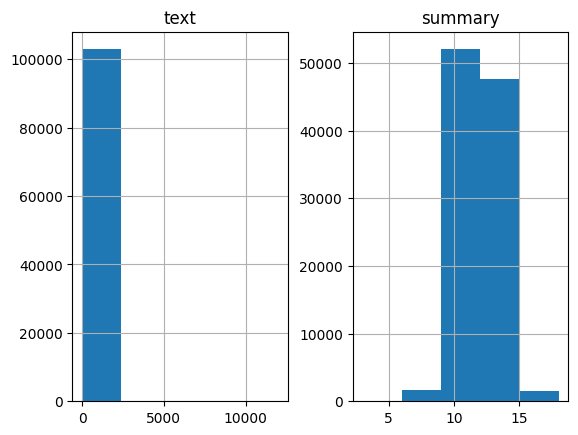

In [16]:
create_word_count_histogram(text, summary)

In [17]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [18]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15
cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [20]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
## Your code here ##
## Design model train ##

In [30]:
## set up otimizer and loss function ##

In [31]:
## Training ##

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")